<a href="https://colab.research.google.com/github/cmucung/eye-retina-disease-classification/blob/main/Copy_of_Carmen_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lesson 3 - Introduction to CNNs
===============================

@AIS 2023 (adapted from @AI4ALL 2022 code)

TA: Priyanshi

In this notebooke, we use Tensorflow/Keras library to play with CNNs.

Keras Documentation: https://keras.io/

Section Overview
- ✅ Importing Dependencies
- ✅ Visualizing an Image through CNN
- ✅ Loading MNIST dataset
- ✅ Constructing a CNN
- ✅ Training a CNN
- ✅ Playground

Importing Dependencies
-----------------------

In [ ]:
!git clone -q https://github.com/Srinivas-R/AI4ALL.git

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal
import requests
import io
import os
from urllib.request import urlopen
from PIL import Image
import pandas as pd
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
import pickle
from keras.utils import to_categorical

Part 1: Using Pre-Trained Models
------------------------------

We use a pretrained `VGG16` CNN.

In [ ]:
# LOAD PRETRAINED VGG16
base_model = VGG16(weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


Part 2: Build Your Own Model:
----------------------



###Loading your Dataset

Load and visualize your dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

directory= "/content/drive/MyDrive/Group 4/Retina Classification/Dataset/archive/Training_Set/Training_Set/Training"

Mounted at /content/drive


# load raw data
training_files = [file for file in os.listdir(directory) if file.endswith('.png')]

csv_file = "/content/drive/MyDrive/Group 4/Retina Classification/Dataset/archive/Training_Set/Training_Set/RFMiD_Training_Labels.csv"
train_labels_df = pd.read_csv(csv_file)
train_labels_df = train_labels_df[["ID", "Disease_Risk"]]

ID_list = []
for file in training_files:
  ID = file.split(".")[0]
  ID = int(ID)
  ID_list.append(ID)

store = []
for index, row in train_labels_df.iterrows():
  if row["ID"] in ID_list:
    store.append(row['ID'])

train_labels_df = train_labels_df[train_labels_df['ID'].isin(store)]
print(train_labels_df)

# LOAD DATASET
import cv2
x_train = []
y_train = []
for index, row in train_labels_df.iterrows():
  img_path = os.path.join(directory, f"{row['ID']}.png")
  img = cv2.imread(img_path)
  img = cv2.resize(img, (224, 224))
  x_train.append(np.array(img))
  y_train.append(row['Disease_Risk'])

load_data = {'X_train': x_train,
        'Y_train': y_train}
pickle.dump(load_data, open('/content/drive/MyDrive/Group 4/Retina Classification/Dataset/archive/Training_Set/training_data.pkl', 'wb'))

In [ ]:
load_df = pickle.load(open('/content/drive/MyDrive/Group 4/Retina Classification/Dataset/archive/Training_Set/training_data.pkl', 'rb'))
x_train = load_df['X_train']
y_train = load_df['Y_train']

Visualize the dataset.

Input Shape:  (224, 3)
Label:  1


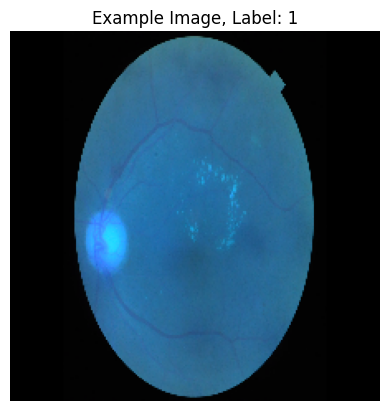

In [ ]:
#EXERCISE 3: VISUALISE AN IMAGE FROM YOUR DATASET

image_number = 55

input_shape = (x_train[image_number].shape[1], x_train[image_number].shape[2])
print('Input Shape: ', input_shape)
print('Label: ', y_train[image_number])


example = x_train[image_number][:,:]
plt.imshow(example, cmap='gray')
plt.axis('off')
plt.title(f"Example Image, Label: {y_train[image_number]}")
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Constructing a CNN

Construct a CNN with keras.Sequential()

In [ ]:
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)

(1450, 224, 224, 3)
(1450,)


In [ ]:
num_classes = 2
y_train = to_categorical(y_train, num_classes = num_classes)
print(y_train.shape)

(1450, 2)


In [ ]:
model = keras.Sequential() #Step #1: Define the model

_, height, width, depth = x_train.shape
input_shape = (height, width, depth)

print(f"Input Shape:", input_shape)
#Step 2: Add layers to the model:

# BLOCK 1
model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu", input_shape=input_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# BLOCK 2
model.add(layers.Conv2D(filters=8, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# CLASSIFIER
model.add(layers.MaxPooling2D(pool_size=(7, 7)))
model.add(layers.Flatten())
model.add(layers.Dense(num_classes))
model.add(layers.Activation("softmax"))

model.summary()

Input Shape: (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 8)         0         
 g2D)                                                            
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                             

Question: Can you figure out the logic for computing number of params ?

###Training a CNN

Define hyperparameters and train the CNN.

Define hyperparameters.

In [ ]:
# HYPERPARAMETRS

# num_epochs - number of times to repeat the training
num_epochs = 10

# batch_size - how many images to train together at each step
batch_size = 128

# learning_rate - the update speed of the network
learning_rate = 1e-3

Compile and start training.

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy']) #Step 3: Compile

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1) #Step 4: Train the model



Epoch 1/10
12/12 [==============================] - 44s 3s/step - loss: 19.8196 - accuracy: 0.7455
Epoch 2/10
12/12 [==============================] - 34s 3s/step - loss: 4.8922 - accuracy: 0.6497
Epoch 3/10
12/12 [==============================] - 39s 3s/step - loss: 2.2871 - accuracy: 0.6414
Epoch 4/10
12/12 [==============================] - 34s 3s/step - loss: 1.6711 - accuracy: 0.6910
Epoch 5/10
12/12 [==============================] - 34s 3s/step - loss: 1.3026 - accuracy: 0.7179
Epoch 6/10
12/12 [==============================] - 36s 3s/step - loss: 1.1109 - accuracy: 0.7207
Epoch 7/10
12/12 [==============================] - 37s 3s/step - loss: 1.0087 - accuracy: 0.7297
Epoch 8/10
12/12 [==============================] - 38s 3s/step - loss: 0.8909 - accuracy: 0.7455
Epoch 9/10
12/12 [==============================] - 45s 4s/step - loss: 0.8007 - accuracy: 0.7441
Epoch 10/10
12/12 [==============================] - 41s 3s/step - loss: 0.7437 - accuracy: 0.7545


###Run Inference on New Data


In [ ]:
img_index = 23 #pick an image to test on from our test array, or try selecting it randomly like we did for visualization!

print(f"Running Model Inference on Image number {img_index}")
img_array = x_train[img_index]
expanded_img_array = np.expand_dims(img_array, axis=(0, 3))

actual_label = y_train[img_index]
actual_label = np.argmax(actual_label)
# Make predictions using the model
predictions = model.predict(expanded_img_array)
predicted_label = np.argmax(predictions[0])  # Get the predicted label

print("Predicted Label:", predicted_label)
print("Actual Label:", actual_label)


Running Model Inference on Image number 23


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 224, 224, 1, 3)


###Cross-Validation

We can use the entirety of the test arrays to compute our model's accuracy and loss on new data to see how it performs.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0) #Step 5: Cross Validation
print('Test loss:', score[0])
print('Test accuracy:', score[1])

For any model, our aim is to minimize the "loss" and maximize the "accuracy". Here accuracy is the cross-validation probability of the event
(predicted label = actual label).

###Saving and Loading the model

We can also save the model for future use.

In [ ]:
# Save the model and its weights
model.save("path_to_save_model.h5")

# Load the saved model
loaded_model = keras.models.load_model("/content/path_to_save_model.h5")

Playground
----------
Try new ideas and play with CNN architecture.

How can we improve model accuracy? Messs around with model architecture and hyperparams to see how it impacts model performance. Here are some ideas

###Conv2D arguments

- Increase Conv2D channels (aka filters)?
- Kernel Size: Adjust the kernel_size parameter in the Conv2D layer to change the size of the convolutional filter. Experiment with different kernel sizes (e.g., 3x3, 5x5) to observe the impact on the model's ability to capture different spatial features.

###Layers:

- Increase the depth: Add more Conv2D layers to the network to increase its depth. You can stack additional convolutional layers to allow the model to learn more complex features and representations.

- Modify the pooling layers: Experiment with adding more MaxPooling2D layers or changing their sizes to alter the downsampling process. This can impact the spatial resolution of the feature maps and the amount of information preserved.

- Change the Dense layers: Add more Dense layers in the classifier part of the network to increase its capacity. You can also experiment with different activation functions in these layers to observe their effect on the model's performance.

###Training Hyperparameters

- Activation Function: Try using different activation functions in the Conv2D and Dense layers, such as ReLU, sigmoid, or tanh. Each activation function has different properties that can impact the model's ability to learn and converge.
- Learning Rate: Experiment with different learning rates to observe their effect on the training process. Higher learning rates may result in faster convergence but may also introduce instability, while lower learning rates may slow down convergence but provide more stable learning.
- Number of Epochs: Increase or decrease the number of training epochs to see how it affects the model's performance. More epochs allow the model to learn for longer, but there's a risk of overfitting if the model is trained for too long.
- Batch Size: Try varying the batch size used during training. Larger batch sizes may accelerate training due to more efficient parallelization, while smaller batch sizes can offer better generalization at the cost of longer training time.

Please record what you have tried and what's the impact here.